In [251]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from keras.initializers import Constant
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SpatialDropout1D, Embedding, LSTM
from tensorflow.keras.layers import Dropout
import re

In [252]:
train = pd.read_csv('Data.csv')
train.head()

,UserId,TweetId,Tweet,ADR_label
0,10030778,413205,Intravenous azithromycin-induced ototoxicity.,1
1,10048291,528244,"Immobilization, while Paget's bone disease was...",1
2,10048291,361834,Unaccountable severe hypercalcemia in a patien...,1
3,10082597,292240,METHODS: We report two cases of pseudoporphyri...,1
4,10082597,467101,METHODS: We report two cases of pseudoporphyri...,1


In [253]:
print("There are {} observations and {} features in this dataset".format(train.shape[0],train.shape[1]))

There are 23516 observations and 4 features in this dataset


In [254]:
#The text seems not to have lot of special characters and requires less of pre-processing techniques
train.Tweet.head(10)

0        Intravenous azithromycin-induced ototoxicity.
1    Immobilization, while Paget's bone disease was...
2    Unaccountable severe hypercalcemia in a patien...
3    METHODS: We report two cases of pseudoporphyri...
4    METHODS: We report two cases of pseudoporphyri...
5    Naproxen, the most common offender, has been a...
6    RESULTS: A 44-year-old man taking naproxen for...
7    RESULTS: A 44-year-old man taking naproxen for...
8    RESULTS: A 44-year-old man taking naproxen for...
9    RESULTS: A 44-year-old man taking naproxen for...
Name: Tweet, dtype: object

In [255]:
#Am using a chunck from stack-overflow to remove all the unwanted digist,special characters and lower all the text to keep the
#tweets clean
def cleaned(text):
    text = re.sub(r"\n","",text)
    text = text.lower()
    text = re.sub(r"\d","",text)        #Remove digits
    text = re.sub(r'[^\x00-\x7f]',r' ',text) # remove non-ascii
    text = re.sub(r'[^\w\s]','',text) #Remove punctuation
    text = re.sub(r'http\S+|www.\S+', '', text) #Remove http
    return text

train['Tweet_clean'] = train['Tweet'].apply(lambda x : cleaned(x))

In [256]:
#Droppig the original Tweet column as it is redundant
train = train.drop(['Tweet'], axis=1)
train.head()

,UserId,TweetId,ADR_label,Tweet_clean
0,10030778,413205,1,intravenous azithromycininduced ototoxicity
1,10048291,528244,1,immobilization while pagets bone disease was p...
2,10048291,361834,1,unaccountable severe hypercalcemia in a patien...
3,10082597,292240,1,methods we report two cases of pseudoporphyria...
4,10082597,467101,1,methods we report two cases of pseudoporphyria...


<AxesSubplot:xlabel='ADR_label', ylabel='count'>

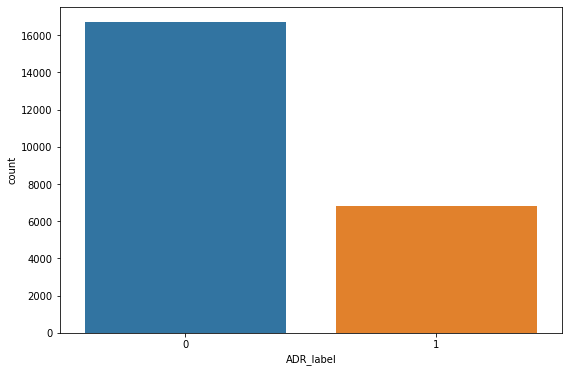

In [257]:
#Trying to have a view on class imbalance in the target feature. 
plt.figure(figsize=(9,6))
sns.countplot(x='ADR_label', data=train)

In [258]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def remove_stopwords(txt):
    txt = [word.lower() for word in txt.split() if word.lower() not in stop]
    return " ".join(txt)

train['Tweet_clean'] = train['Tweet_clean'].apply(lambda x : remove_stopwords(x))

In [259]:
#Am creating the corpus for target label 1 and 0 given to us. 
# Create the function to make the corpus
def create_corpus(target):
    corpus=[]
    for x in train[train['ADR_label']==target]['Tweet_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus_positive = create_corpus(1) # corpus for the positive tweets
corpus_negative = create_corpus(0) # corpus for the negative tweets

print('Length of positive corpus is', len(corpus_positive))
print('Length of negative corpus is', len(corpus_negative))

Length of positive corpus is 90838
Length of negative corpus is 183593


<BarContainer object of 30 artists>

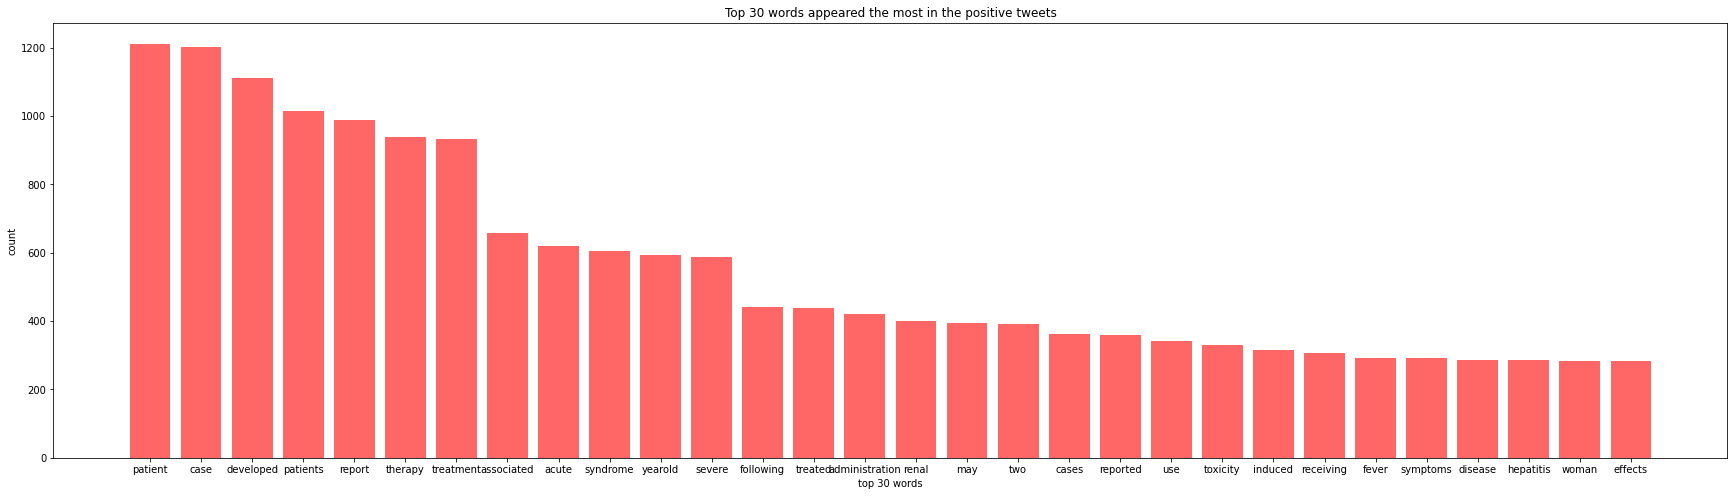

In [280]:
# Let's create the function to extract the most common 30 words from the corpus 
def common_word(corpus):
    for idx, low in enumerate(corpus):
        corpus[idx] = low.lower()
    counter = Counter(corpus)
    stop_word_dict = {}
    for i in range(1,31):
        for stop in counter.most_common(i):
            stop_key = str(stop[0])
            stop_value = stop[1]
            stop_word_dict[stop_key] = stop_value
    return stop_word_dict

common_positive = common_word(corpus_positive)
common_positive_sorted = sorted(common_positive.items(), key=lambda x:x[1], reverse=True)

# Let's show the words and how many did they appear in the positive tweets
word_count_list, common_word_list = [], []
for word_count in common_positive_sorted:
  common_word_list.append(word_count[0])
  word_count_list.append(word_count[1])

plt.figure(figsize=(30,8))
plt.title('Top 30 words appeared the most in the positive tweets')
plt.xlabel('top 30 words')
plt.ylabel('count')
plt.bar(common_word_list, word_count_list, alpha=0.6, color='r')

<BarContainer object of 30 artists>

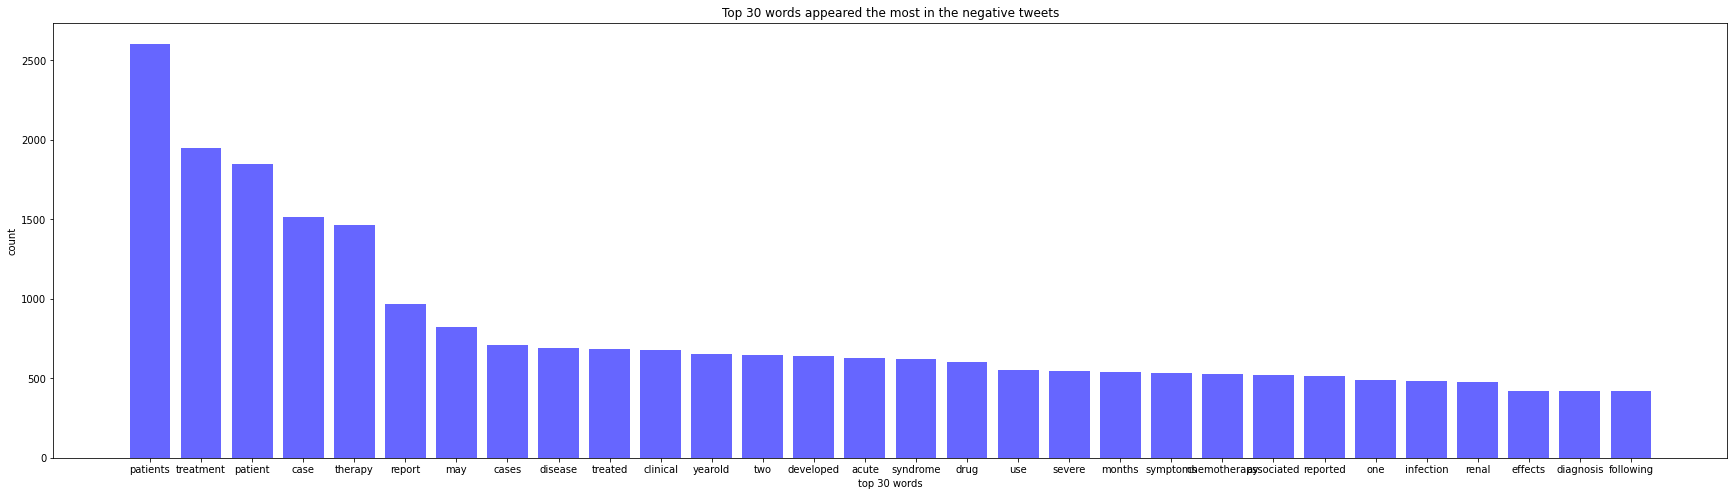

In [281]:
# Let's show the words and how many did they appear in the negative tweets
common_negative = common_word(corpus_negative)
common_negative_sorted = sorted(common_negative.items(), key=lambda x:x[1], reverse=True)
word_count_list, common_word_list = [], []
for word_count in common_negative_sorted:
  common_word_list.append(word_count[0])
  word_count_list.append(word_count[1])

plt.figure(figsize=(30,8))
plt.title('Top 30 words appeared the most in the negative tweets')
plt.xlabel('top 30 words')
plt.ylabel('count')
plt.bar(common_word_list, word_count_list, alpha=0.6, color='b')

In [262]:
# Count the max length of tweet in both train and test data for converting tweets into sequences
max_len = 0
for i in train['Tweet_clean']:
  split_i = i.split()
  if len(split_i) > max_len:
    max_len = len(split_i)

print('Max length of tweets :', max_len)

Max length of tweets : 66


In [263]:
x = train.drop("ADR_label",axis=1)
y = train['ADR_label']

train.head()

,UserId,TweetId,ADR_label,Tweet_clean
0,10030778,413205,1,intravenous azithromycininduced ototoxicity
1,10048291,528244,1,immobilization pagets bone disease present per...
2,10048291,361834,1,unaccountable severe hypercalcemia patient tre...
3,10082597,292240,1,methods report two cases pseudoporphyria cause...
4,10082597,467101,1,methods report two cases pseudoporphyria cause...


In [264]:
# Convert the tweets into the sequences in train and test data
max_fatures = 30000# the number of words to be used for the input of embedding layer
tokenizer = Tokenizer(num_words=max_fatures, split=' ') #Create the instance of Tokenizer
tokenizer.fit_on_texts(train['Tweet_clean'].values)
train_converted = tokenizer.texts_to_sequences(train['Tweet_clean'].values)
train_converted = pad_sequences(train_converted, maxlen=max_len) # Turning the vectors of train data into sequences 


In [277]:
train_converted

array([[    0,     0,     0, ...,    74, 11966,  1948],
       [    0,     0,     0, ...,    90, 11968,  2008],
       [    0,     0,     0, ...,    14,  3330,  7756],
       ...,
       [    0,     0,     0, ...,  9042,   454,   114],
       [    0,     0,     0, ..., 11732,  2650,  1123],
       [    0,     0,     0, ...,  1450,    47,    27]])

In [265]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_converted,train['ADR_label'], test_size = 0.1, random_state = 42)

In [266]:

print('The shape of train data :', X_train.shape)
print('The shape of labels of train data :', Y_train.shape)
print('The shape of test data :', X_test.shape)
print('The shape of test label data :', Y_test.shape)

The shape of train data : (21164, 66)
The shape of labels of train data : (21164,)
The shape of test data : (2352, 66)
The shape of test label data : (2352,)


In [267]:
import xgboost as xgb
XGB_classifier = xgb.XGBClassifier()
XGB_classifier.fit(X_train, Y_train)

y_pred = XGB_classifier.predict(X_test)

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(Y_test, y_pred)

print('\n Accuracy: ', accuracy_score(Y_test, y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Accuracy:  0.8499149659863946

Classification Report

               precision    recall  f1-score   support

           0       0.86      0.94      0.90      1671
           1       0.81      0.63      0.71       681

    accuracy                           0.85      2352
   macro avg       0.84      0.78      0.80      2352
weighted avg       0.85      0.85      0.84      2352



In [278]:
prediction = XGB_classifier.predict(X_test)
X_test

array([[   0,    0,    0, ...,   15,   20,   46],
       [   0,    0,    0, ..., 5799,  487,  353],
       [   0,    0,    0, ..., 7114,   10,   64],
       ...,
       [   0,    0,    0, ...,   38,  518, 3154],
       [   0,    0,    0, ..., 3109, 5857, 1815],
       [   0,    0,    0, ..., 4019,  138,    5]])

In [279]:
prediction

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)